# DeepTesla C
Proyecto basado en http://selfdrivingcars.mit.edu/deeptesla/

### Objetivo
* Diseñar e implementar una CNN para predecir el ángulo de viraje a partir de imágenes tomadas por la cámara frontal del vehículo.

### Recursos
* Dataset: https://pan.baidu.com/s/1c2J2IFA#list/path=%2F%E5%85%B1%E4%BA%AB%2Fdeeptesla&parentPath=%2F%E5%85%B1%E4%BA%AB
* Documentación de Keras: https://keras.io/

## Extracción de frames de los videos

In [ ]:
from __future__ import print_function

import numpy as np
import cv2
import os

base_path = "J:/Datasets/deeptesla/"
validation_set = [9, 10]
frames_writed = 0

for video_id in xrange(1, 11):
    video_filename = "epoch%02d_front.mkv" % video_id
    video_path = os.path.join(base_path, video_filename)
    assert os.path.isfile(video_path)

    # Create capturator
    cap = cv2.VideoCapture(video_path)
    print("Capturing from ", video_path)

    # Capture first frame
    ret, frame = cap.read()
    assert ret

    # Print shape
    shape = frame.shape
    print(shape)

    while (ret):
        # Crop frame 
        img = frame[int(shape[0]/2):shape[0], 0:shape[1]]
        # Resize the image
        img = cv2.resize(img, (128, 64), interpolation=cv2.INTER_AREA)
        # Resize the image sized as a 4D array
        img = np.resize(img, (64, 128, 3))
        
        # Save the image
        if video_id in validation_set:
            image_path = os.path.join(base_path, "validation/frame%05d.jpg" % frames_writed)
        else:
            image_path = os.path.join(base_path, "training/frame%05d.jpg" % frames_writed)
        cv2.imwrite(image_path, img)
        frames_writed += 1
        if frames_writed % 100 == 0:
            print("Writed %d images..." % frames_writed)

        # Display
        #cv2.imshow('frame', frame)
        #cv2.imshow('img', img)

        # User exit?
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Capture next frame
        ret, frame = cap.read()

    # Release the capture
    cap.release()

cv2.destroyAllWindows()


## Una primera mirada a los datos

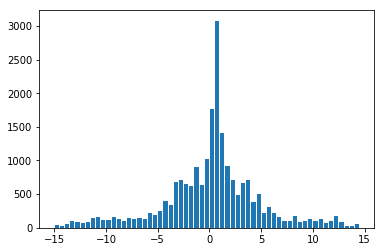

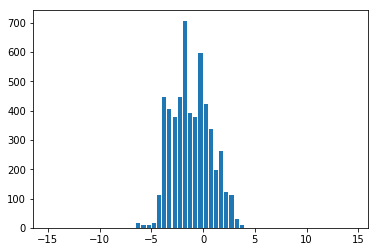

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

step = 0.5

y_train = np.genfromtxt("/mnt/j/Datasets/deeptesla/training.csv", delimiter = ',')
y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')

y_train_hist, bins = np.histogram(y_train, bins = np.arange(-15, 15, step))
y_test_hist, bins = np.histogram(y_test, bins = bins)

width = 0.8 * step
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, y_train_hist, align='center', width=width)
plt.show()
plt.bar(center, y_test_hist, align='center', width=width)
plt.show()


## Entrenamiento de la CNN

In [1]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import EarlyStopping

from PIL import Image
import glob
import os
import pickle
import numpy as np
#import scipy

epochs = 10

batch_size = 16
print("batch_size = %d" % batch_size)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'deeptesla_trained_model.h5'

x_train = []
x_test = []

filelist = glob.glob("/mnt/j/Datasets/deeptesla/training/*.jpg")
for fname in filelist:
    x_train.append(np.array(Image.open(fname)))
x_train = np.array(x_train)
print(x_train.shape)
print(x_train[0].shape)

filelist = glob.glob("/mnt/j/Datasets/deeptesla/validation/*.jpg")
for fname in filelist:
     x_test.append(np.array(Image.open(fname)))
x_test = np.array(x_test)
        
y_train = np.genfromtxt("/mnt/j/Datasets/deeptesla/training.csv", delimiter = ',')
y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')
print(y_train.shape)

model = Sequential()
model.add(Conv2D(8, (3, 3), padding = 'same',
                 input_shape = x_train[0].shape))
model.add(Activation('relu'))

model.add(AveragePooling2D(pool_size = (2, 2),
                           strides = (2, 2)))

model.add(Conv2D(8, (3, 3), padding = 'same',
                 kernel_initializer = 'glorot_uniform'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2),
                       strides = (2, 2)))

model.add(Conv2D(8, (3, 3), padding = 'same',
                 kernel_initializer = 'glorot_uniform'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2),
                       strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adadelta')
model.summary()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.001,
                          patience = 1,
                          verbose = 1)

model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_test, y_test),
#          shuffle = False,
#          callbacks = [earlystop],
          verbose = 2)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print('Saved trained model at %s ' % model_path)


Using TensorFlow backend.


batch_size = 16
(21600, 64, 128, 3)
(64, 128, 3)
(21600,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 128, 8)        224       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 8)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 64, 8)         584       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 64, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D) 